#### Simple DQN RL Stock Trader (Part1)
 - Simple stock trading RL-based algo trading agaent using S & P 500 data
 - Trading actions are buy, sell or hold
 - Trading window is daily   
 - References:
    - Yves J Hilpisch, "Artificial Intelligence in Finance", page 268 - 276, O'Reilly, 2021
    - Hariom Tatsat, Sahil Puri & Brad Lookabaugh, "Machine Learning and Data Science Blueprints for Finance", page 298 - 316, O'Reilly, 2021
    - Mnih, V. et al., "Human-level control through deep reinforcement learning", Nature, 2015.
    - Moody, J., Saffell, M., "Learning to trade via direct reinforcement", IEEE, 2001.
    - Gymnasium API documentation: https://gymnasium.farama.org/
    - PyTorch documentation: https://pytorch.org/docs/stable/index.html

#### Imports

In [1]:
import math
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque
import ta
import random
import os, sys
from typing import Tuple, List, Any, Dict
import pandas as pd
from IPython.display import display
from tqdm import tqdm

from stable_baselines3 import DQN, PPO
from stable_baselines3.common.evaluation import evaluate_policy

sys.path.insert(1, "../")

import src.main.configs.global_configs as configs
from src.main.utility.utils import Helpers
from src.main.utility.data_provider import DataProvider
from src.main.rl_algorithms.train_evaluate_test.dqn_algorithm import DQNTrainAlgorithm
from src.main.rl_algorithms.hyper_parameter_tuning.dqn_hyper_parameter_tuning import DQNHyperParameterTuning
from src.main.utility.enum_types import RLAgorithmType
from src.main.utility.chart_results import ChartResults
from src.main.environment.rl_algo_trader_env import TradingEnv
from src.main.rl_agents.rl_algo_trading_agent import RLAlgoTradingAgent


#### Exploratory data analysis of the S & P 500 price data

In [2]:
df = Helpers.getAssetData()
print(f"df.shape[0]: {df.shape[0]}\n")
df.head()

./data/s_and_p_raw_data_with_features.csv already exists in local file system (cache), ingesting the file locally
./data/s_and_p_scaled_data_with_features.csv already exists in local file system (cache), ingesting the file locally
df.shape[0]: 2516



,Close,High,Low,Open,Volume
0,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
1,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
3,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
4,1144.979980,1145.390015,1136.219971,1140.520020,4389590000


##### The RL solution will use the 'Close' column (bar) of the dataset

Text(0.5, 1.0, 'S & P Closing Price 2010 to 2019')

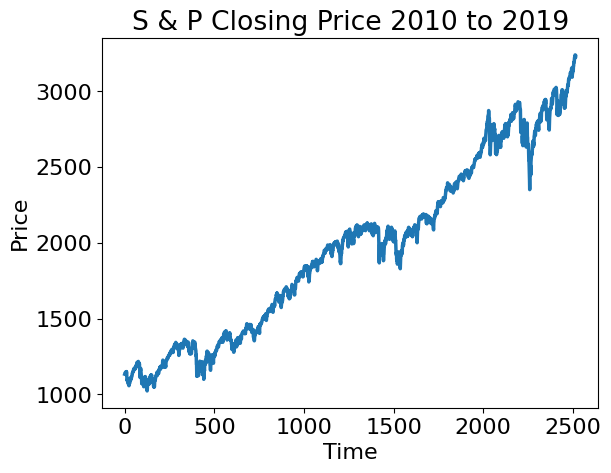

In [3]:
plt.plot(df.Close)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("S & P Closing Price 2010 to 2019")

#### Steps for training and evaluating the RL algo trader

The RL data will be partitioned into:
 - 80% training (in-sample) data i.e. 2010-01-04 to 2017-12-26
 - 20% test (out-of-sample) data i.e. 2017-12-27 to 2019-12-31

Steps include:
 - Step 1: Instantiate the algo trading environments (train/test)
 - Step 2: Let us start with a random (dumb/naive) agent rgar trades randomly..
 - Step 3: Train and evaluate the RL trading agent with a DQN RL algorithm:
   - Step 3.1: Run the training cycle:
     - Instantiate the agent DQN (Deep Q Network)
       - Will also consider a more optimal model later, PPO - Proximal Policy Optimization)
     - Step 3.2: Evaluate the performance of the trained RL agent model from the reward curves
   - Step 3.3: Get the RL infos data on completion of the train cycle and plot the trading bot behaviour
   - Step 3.4: Use the out-of-sample data (the set aside 20%) to test the performance of trading RL agent bot
 - Step 4: Train and evaluate the RL trading agent with a PPO algorithm:
   - PPO is a much more optimal RL agent compared to DQN 

##### Step 1: Instantiate the algo trading environments (train/test)

In [4]:
agent = RLAlgoTradingAgent(rl_algorithm_type=RLAgorithmType.dqn)

2025-06-15 16:55:57,039 - INFO - rl_algo_trading_agent.py:_createAlgoTradingEnvironments - : Creating the 'train' RL algo trading environment.. in C:\Development\Python\AI\ReinforcementLearning\PyData2025-Presentation\repo\Hands-on-workshop-on-Reinforcement-Learning-Pydata2025\demos\rl-robo-algo-trader\notebooks\..\src\main\rl_agents\rl_algo_trading_agent.py:135
2025-06-15 16:55:57,043 - INFO - rl_algo_trading_agent.py:_createAlgoTradingEnvironments - : Creating the 'test' RL algo trading environment.. in C:\Development\Python\AI\ReinforcementLearning\PyData2025-Presentation\repo\Hands-on-workshop-on-Reinforcement-Learning-Pydata2025\demos\rl-robo-algo-trader\notebooks\..\src\main\rl_agents\rl_algo_trading_agent.py:138
2025-06-15 16:55:57,067 - INFO - dqn_algorithm.py:__init__ - : Start of Reinforcement learning for environment: RL-ALGO-TRADER in C:\Development\Python\AI\ReinforcementLearning\PyData2025-Presentation\repo\Hands-on-workshop-on-Reinforcement-Learning-Pydata2025\demos\rl-r

./data/s_and_p_raw_data_with_features.csv already exists in local file system (cache), ingesting the file locally
./data/s_and_p_scaled_data_with_features.csv already exists in local file system (cache), ingesting the file locally
./data/s_and_p_raw_data_with_features.csv already exists in local file system (cache), ingesting the file locally
./data/s_and_p_scaled_data_with_features.csv already exists in local file system (cache), ingesting the file locally
./data/s_and_p_raw_data_with_features.csv already exists in local file system (cache), ingesting the file locally
./data/s_and_p_scaled_data_with_features.csv already exists in local file system (cache), ingesting the file locally


2025-06-15 16:55:57,068 - INFO - dqn_algorithm.py:__init__ - : This RL environment uses a DQN RL algorithm agent in C:\Development\Python\AI\ReinforcementLearning\PyData2025-Presentation\repo\Hands-on-workshop-on-Reinforcement-Learning-Pydata2025\demos\rl-robo-algo-trader\notebooks\..\src\main\rl_algorithms\train_evaluate_test\dqn_algorithm.py:48
2025-06-15 16:55:57,069 - INFO - base_algorithms.py:hyper_parameters - : Training is using non-tuned hyperparameters... in C:\Development\Python\AI\ReinforcementLearning\PyData2025-Presentation\repo\Hands-on-workshop-on-Reinforcement-Learning-Pydata2025\demos\rl-robo-algo-trader\notebooks\..\src\main\rl_algorithms\train_evaluate_test\base_algorithms.py:119
2025-06-15 16:55:57,070 - INFO - base_algorithms.py:hyper_parameters - : Hyperparameters are:
{'gamma': 0.9999, 'learning_rate': 0.0005, 'batch_size': 128, 'policy_kwargs': {'net_arch': [64, 64]}} in C:\Development\Python\AI\ReinforcementLearning\PyData2025-Presentation\repo\Hands-on-worksho

##### Step 2: Let us start with a random (dumb/naive) agent which trades randomly..

,action,state,next_state,reward,done,truncated,info
0,2,"[[-1.387680657537328, 1.2870908458883237, -1.3989350350141292, 0.4182261720966533, -0.2181065340...","[[-1.408419410931393, -1.186995451632294, -1.3986756380979906, -0.10695296023835295, -0.02420190...",0,False,False,"{'states_buy': [8, 11, 13, 16, 17, 25, 30, 32, 33, 34, 36, 40, 44, 47, 50, 51, 55, 60, 62, 63, 6..."
1,2,"[[-1.408419410931393, -1.186995451632294, -1.3986756380979906, -0.10695296023835295, -0.02420190...","[[-1.4450995493698042, -2.0953261964462477, -1.4022013488164082, -0.8574923835276377, 0.40109701...",0,False,False,"{'states_buy': [8, 11, 13, 16, 17, 25, 30, 32, 33, 34, 36, 40, 44, 47, 50, 51, 55, 60, 62, 63, 6..."
2,0,"[[-1.4450995493698042, -2.0953261964462477, -1.4022013488164082, -0.8574923835276377, 0.40109701...","[[-1.4871556478558698, -2.445172710576661, -1.4107220750467788, -1.8640728399847282, 0.740563381...",0,False,False,"{'states_buy': [8, 11, 13, 16, 17, 25, 30, 32, 33, 34, 36, 40, 44, 47, 50, 51, 55, 60, 62, 63, 6..."
3,1,"[[-1.4871556478558698, -2.445172710576661, -1.4107220750467788, -1.8640728399847282, 0.740563381...","[[-1.4786150861236693, 0.4471270153233299, -1.4189475737558261, -1.79883277886035, 0.76789480892...",0,False,False,"{'states_buy': [8, 11, 13, 16, 17, 25, 30, 32, 33, 34, 36, 40, 44, 47, 50, 51, 55, 60, 62, 63, 6..."
4,0,"[[-1.4786150861236693, 0.4471270153233299, -1.4189475737558261, -1.79883277886035, 0.76789480892...","[[-1.486458056501467, -0.49629923775084145, -1.4283010907440254, -2.026118971424018, 0.728327657...",0,False,False,"{'states_buy': [8, 11, 13, 16, 17, 25, 30, 32, 33, 34, 36, 40, 44, 47, 50, 51, 55, 60, 62, 63, 6..."
5,0,"[[-1.486458056501467, -0.49629923775084145, -1.4283010907440254, -2.026118971424018, 0.728327657...","[[-1.4773901996073646, 0.4772240320142219, -1.4349087959654936, -1.480775770504113, 0.7818672783...",0,False,False,"{'states_buy': [8, 11, 13, 16, 17, 25, 30, 32, 33, 34, 36, 40, 44, 47, 50, 51, 55, 60, 62, 63, 6..."
6,1,"[[-1.4773901996073646, 0.4772240320142219, -1.4349087959654936, -1.480775770504113, 0.7818672783...","[[-1.499456017233235, -1.319267312021307, -1.4453442722397845, -2.2506796585752418, 0.6743351308...",0,False,False,"{'states_buy': [8, 11, 13, 16, 17, 25, 30, 32, 33, 34, 36, 40, 44, 47, 50, 51, 55, 60, 62, 63, 6..."
7,0,"[[-1.499456017233235, -1.319267312021307, -1.4453442722397845, -2.2506796585752418, 0.6743351308...","[[-1.517591938699723, -1.1037357947123088, -1.4580733238808339, -2.7200059099723934, 0.614159187...",0,False,False,"{'states_buy': [8, 11, 13, 16, 17, 25, 30, 32, 33, 34, 36, 40, 44, 47, 50, 51, 55, 60, 62, 63, 6..."
8,1,"[[-1.517591938699723, -1.1037357947123088, -1.4580733238808339, -2.7200059099723934, 0.614159187...","[[-1.4915281064374704, 1.4739782507173362, -1.4660667569260695, -1.7643807988014106, 0.959850669...",0,False,False,"{'states_buy': [8, 11, 13, 16, 17, 25, 30, 32, 33, 34, 36, 40, 44, 47, 50, 51, 55, 60, 62, 63, 6..."
9,2,"[[-1.4915281064374704, 1.4739782507173362, -1.4660667569260695, -1.7643807988014106, 0.959850669...","[[-1.4674887220831423, 1.337198528238126, -1.4740721265624503, -1.7465494385953442, 0.9741074371...",0,False,False,"{'states_buy': [8, 11, 13, 16, 17, 25, 30, 32, 33, 34, 36, 40, 44, 47, 50, 51, 55, 60, 62, 63, 6..."


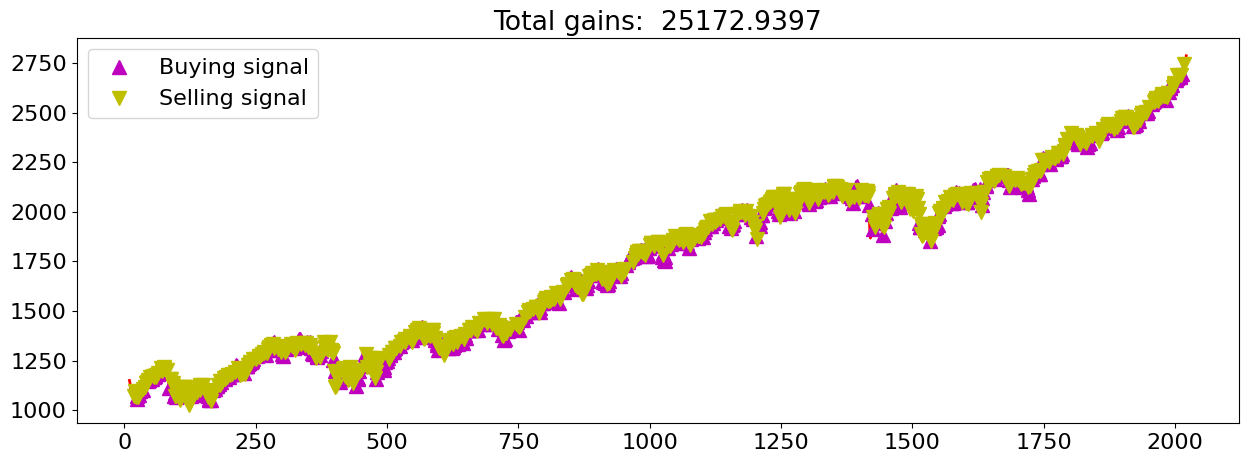

In [5]:
agent.trainRLWithRandomAgent()

#####  Step 3.1: Run the training cycle with the DQN agent

In [6]:
train_infos = agent.train()

2025-06-15 16:56:01,240 - INFO - rl_algo_trading_agent.py:train - : Training RL algo trading agent with the RLAgorithmType.dqn algorithm in C:\Development\Python\AI\ReinforcementLearning\PyData2025-Presentation\repo\Hands-on-workshop-on-Reinforcement-Learning-Pydata2025\demos\rl-robo-algo-trader\notebooks\..\src\main\rl_agents\rl_algo_trading_agent.py:45
2025-06-15 16:56:01,243 - INFO - save_on_base_reward_callback.py:_init_callback - : Saving trained RL model to ./logs/RL-Algo-Trader_dqn\best_model in C:\Development\Python\AI\ReinforcementLearning\PyData2025-Presentation\repo\Hands-on-workshop-on-Reinforcement-Learning-Pydata2025\demos\rl-robo-algo-trader\notebooks\..\src\main\rl_algorithms\train_evaluate_test\save_on_base_reward_callback.py:47
2025-06-15 16:56:04,271 - INFO - save_on_base_reward_callback.py:_on_step - : Saving new best model to ./logs/RL-Algo-Trader_dqn\best_model.zip in C:\Development\Python\AI\ReinforcementLearning\PyData2025-Presentation\repo\Hands-on-workshop-on-

Num timesteps: 3000
Best mean reward: -inf - Last mean reward per episode: 19930.41
Num timesteps: 4000
Best mean reward: 19930.41 - Last mean reward per episode: 19930.41
Num timesteps: 5000
Best mean reward: 19930.41 - Last mean reward per episode: 12361.62
Num timesteps: 6000
Best mean reward: 19930.41 - Last mean reward per episode: 12361.62
Num timesteps: 7000
Best mean reward: 19930.41 - Last mean reward per episode: 9736.42
Num timesteps: 8000
Best mean reward: 19930.41 - Last mean reward per episode: 9736.42
Num timesteps: 9000
Best mean reward: 19930.41 - Last mean reward per episode: 7764.29
Num timesteps: 10000
Best mean reward: 19930.41 - Last mean reward per episode: 7764.29
Eval num_timesteps=10000, episode_reward=3839.15 +/- 0.00
Episode length: 2007.00 +/- 0.00
New best mean reward!
Num timesteps: 11000
Best mean reward: 19930.41 - Last mean reward per episode: 5583.66
Num timesteps: 12000
Best mean reward: 19930.41 - Last mean reward per episode: 5583.66
Num timesteps:

##### Step 3.2: Evaluate the performance of the trained RL agent model from the reward curves

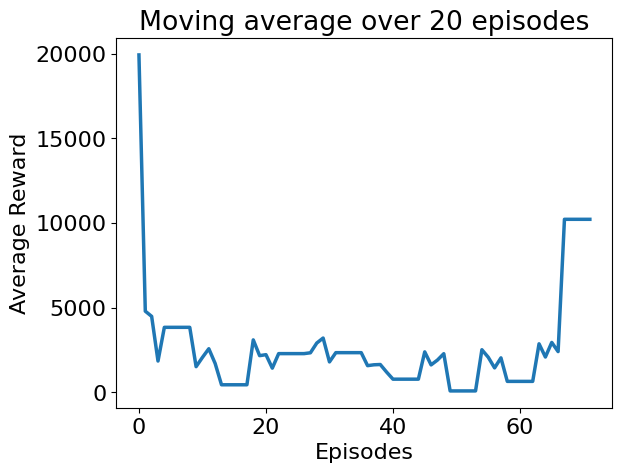

In [7]:
agent.plotTrainRewardCurve()

##### Step 3.3: Get the RL infos data on completion of the train cycle and plot the trading bot behaviour

number of buys: 492	 number of sells: 416


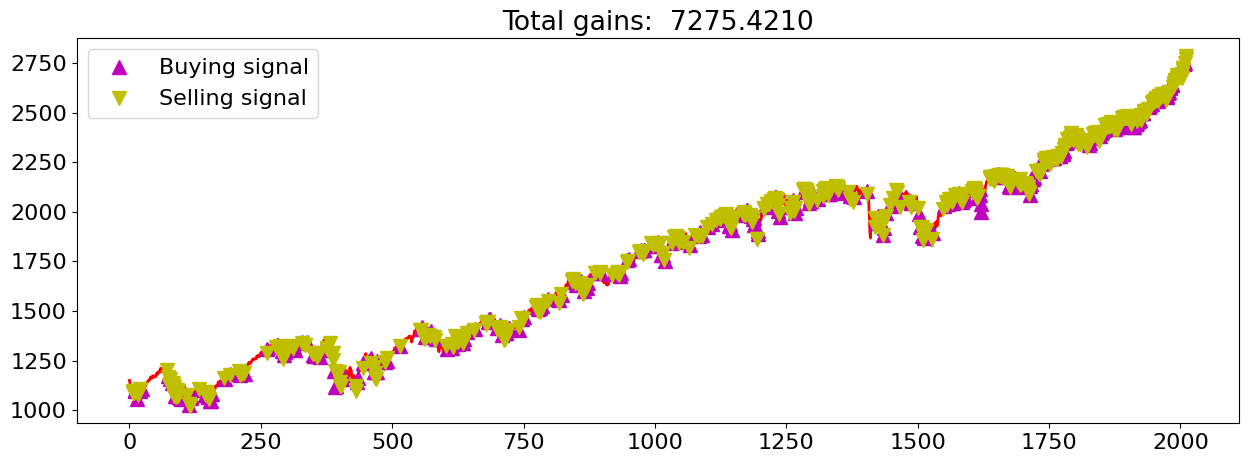

In [8]:
infos = train_infos[-1]
n_buys = len(infos["states_buy"])
n_sells = len(infos["states_sell"])
print(f"number of buys: {n_buys}\t number of sells: {n_sells}")
agent.reportAgentBehaviour(agent.train_env, infos)


##### Step 3.4: Use the out-of-sample data (the set aside 20%) to test the performance of trading RL agent bot

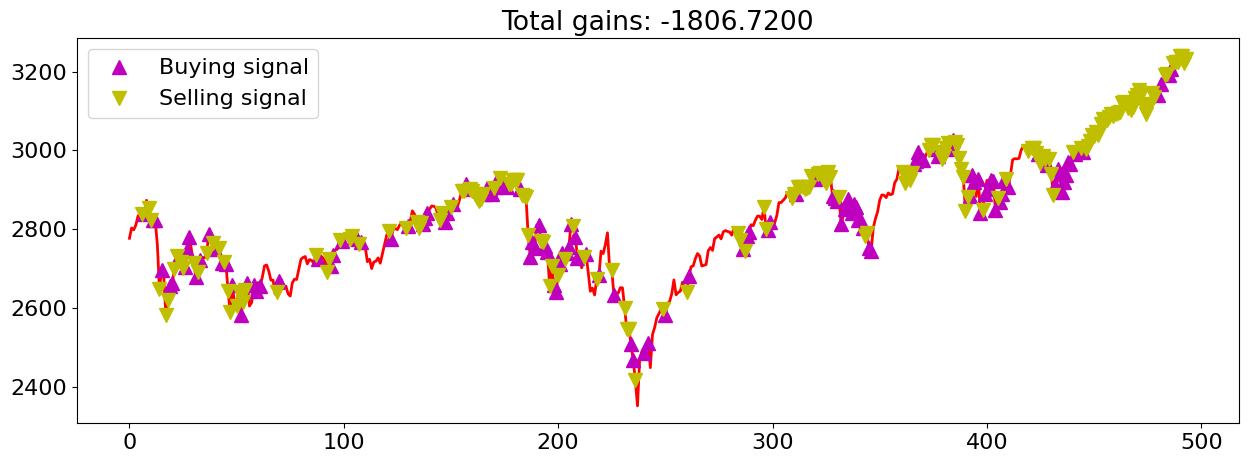

In [9]:
rewards, infos = agent.validate()

#### Step 4: Train and evaluate the RL trading agent with a PPO algorithm
 - PPO is a well known RL algorithm that can be used for continuous and discrete action spaces
 - For the algo trader will now PPO as an alternative to the DQN algorithm

In [10]:
def demoPPOAgent():
    """
    Demos the use of PPO RL algorithm as the algo trader agent
    """
    rl_algo = RLAgorithmType.ppo
    agent = RLAlgoTradingAgent(rl_algorithm_type=rl_algo)
    infos_all_episode = agent.train()
    infos_last_episode = infos_all_episode[-1]
    agent.reportAgentBehaviour(agent.train_env, infos_last_episode)
    rewards, infos = agent.validate()
    

2025-06-15 16:58:30,496 - INFO - rl_algo_trading_agent.py:_createAlgoTradingEnvironments - : Creating the 'train' RL algo trading environment.. in C:\Development\Python\AI\ReinforcementLearning\PyData2025-Presentation\repo\Hands-on-workshop-on-Reinforcement-Learning-Pydata2025\demos\rl-robo-algo-trader\notebooks\..\src\main\rl_agents\rl_algo_trading_agent.py:135
2025-06-15 16:58:30,514 - INFO - rl_algo_trading_agent.py:_createAlgoTradingEnvironments - : Creating the 'test' RL algo trading environment.. in C:\Development\Python\AI\ReinforcementLearning\PyData2025-Presentation\repo\Hands-on-workshop-on-Reinforcement-Learning-Pydata2025\demos\rl-robo-algo-trader\notebooks\..\src\main\rl_agents\rl_algo_trading_agent.py:138
2025-06-15 16:58:30,529 - INFO - ppo_algorithm.py:__init__ - : Start of Reinforcement learning for environment: RL-ALGO-TRADER in C:\Development\Python\AI\ReinforcementLearning\PyData2025-Presentation\repo\Hands-on-workshop-on-Reinforcement-Learning-Pydata2025\demos\rl-r

./data/s_and_p_raw_data_with_features.csv already exists in local file system (cache), ingesting the file locally
./data/s_and_p_scaled_data_with_features.csv already exists in local file system (cache), ingesting the file locally
./data/s_and_p_raw_data_with_features.csv already exists in local file system (cache), ingesting the file locally
./data/s_and_p_scaled_data_with_features.csv already exists in local file system (cache), ingesting the file locally
./data/s_and_p_raw_data_with_features.csv already exists in local file system (cache), ingesting the file locally
./data/s_and_p_scaled_data_with_features.csv already exists in local file system (cache), ingesting the file locally


2025-06-15 16:58:34,430 - INFO - save_on_base_reward_callback.py:_on_step - : Saving new best model to ./logs/RL-Algo-Trader_ppo\best_model.zip in C:\Development\Python\AI\ReinforcementLearning\PyData2025-Presentation\repo\Hands-on-workshop-on-Reinforcement-Learning-Pydata2025\demos\rl-robo-algo-trader\notebooks\..\src\main\rl_algorithms\train_evaluate_test\save_on_base_reward_callback.py:68


Num timesteps: 3000
Best mean reward: -inf - Last mean reward per episode: 36737.30
Num timesteps: 4000
Best mean reward: 36737.30 - Last mean reward per episode: 36737.30
Num timesteps: 5000
Best mean reward: 36737.30 - Last mean reward per episode: 26807.18
Num timesteps: 6000
Best mean reward: 36737.30 - Last mean reward per episode: 26807.18
Num timesteps: 7000
Best mean reward: 36737.30 - Last mean reward per episode: 31952.31
Num timesteps: 8000
Best mean reward: 36737.30 - Last mean reward per episode: 31952.31
Num timesteps: 9000
Best mean reward: 36737.30 - Last mean reward per episode: 27986.11
Num timesteps: 10000
Best mean reward: 36737.30 - Last mean reward per episode: 27986.11
Eval num_timesteps=10000, episode_reward=15971.04 +/- 0.00
Episode length: 2007.00 +/- 0.00
New best mean reward!
Stopping training because the mean reward 15971.04  is above the threshold 10000


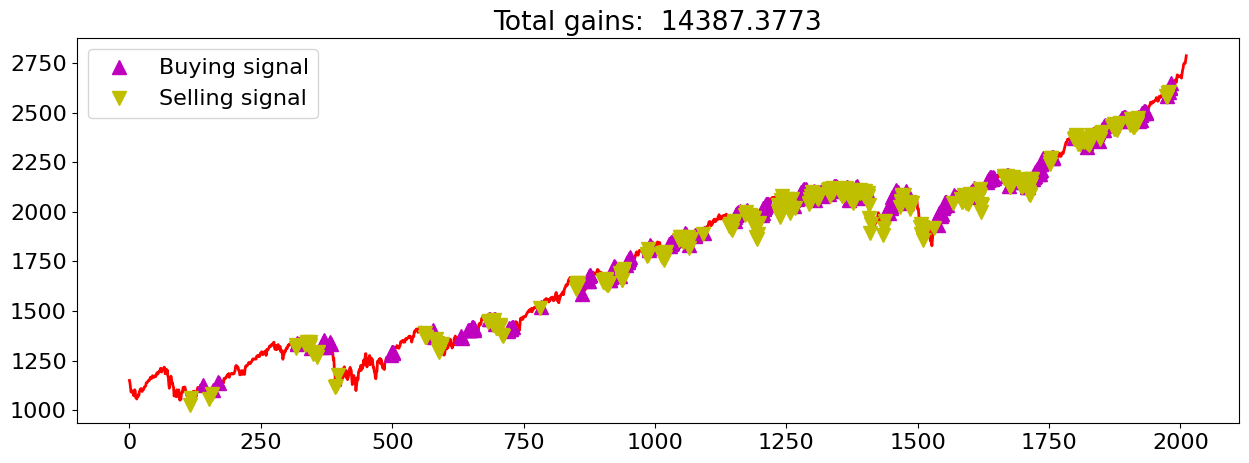

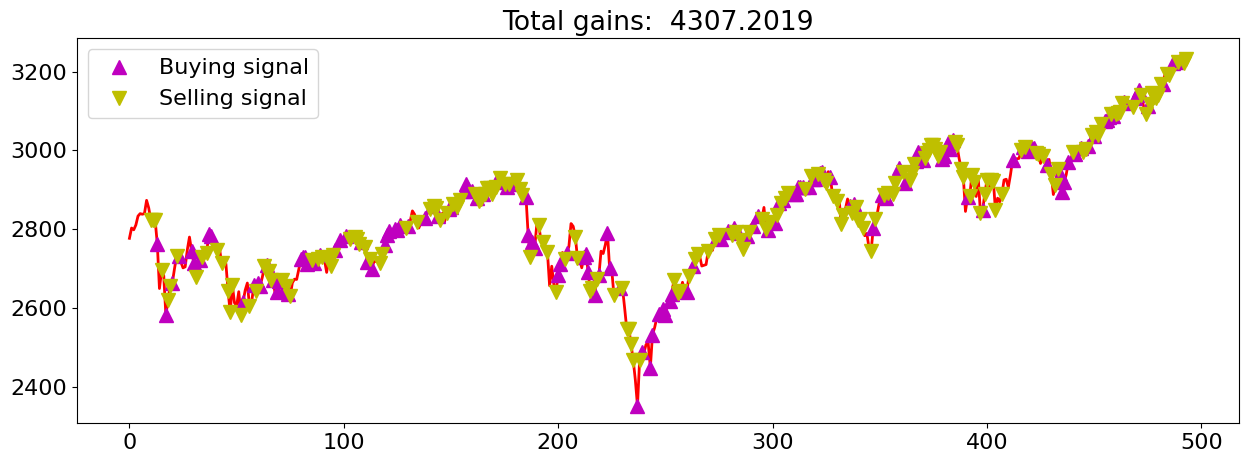

In [11]:
demoPPOAgent()